In [21]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.95' 

import tensorflow as tf
tf.config.experimental.set_visible_devices([], "GPU")

from classification.default_loader import get_base_dataloaders, CIFAR10_MEANS, CIFAR10_STD
# from sas_stack.sars_dataloader import get_sars_dataloaders
# from sa_stack import get_sar_dataloaders, TrainerModule, RegressionInceptionNetV1
from td_sa_stack import get_sarsa_opt_dataloaders, TrainerModule, RegressionInceptionNetV1

import jax
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from flax import linen as nn

import numpy as np

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
jax.devices()

[CudaDevice(id=0)]

In [8]:
bs = 512

train_loader, val_loader = get_sarsa_opt_dataloaders(batch_size=bs,
                                               reward=10,
                                               gamma=0.9,
                                               min_num_steps=5,
                                               max_num_steps=23,
                                               with_shuffled_transitions=True)

In [9]:
train_iter = iter(train_loader)
images, rewards = next(train_iter)

val_iter = iter(val_loader)
val_images, val_rewards = next(val_iter)

In [10]:
states = val_images[..., :3]
actions = val_images[..., 3:6]
states_next = val_images[..., 6:9] if val_images.shape[-1] > 6 else None
actions_next = val_images[..., 9:] if val_images.shape[-1] > 9 else None

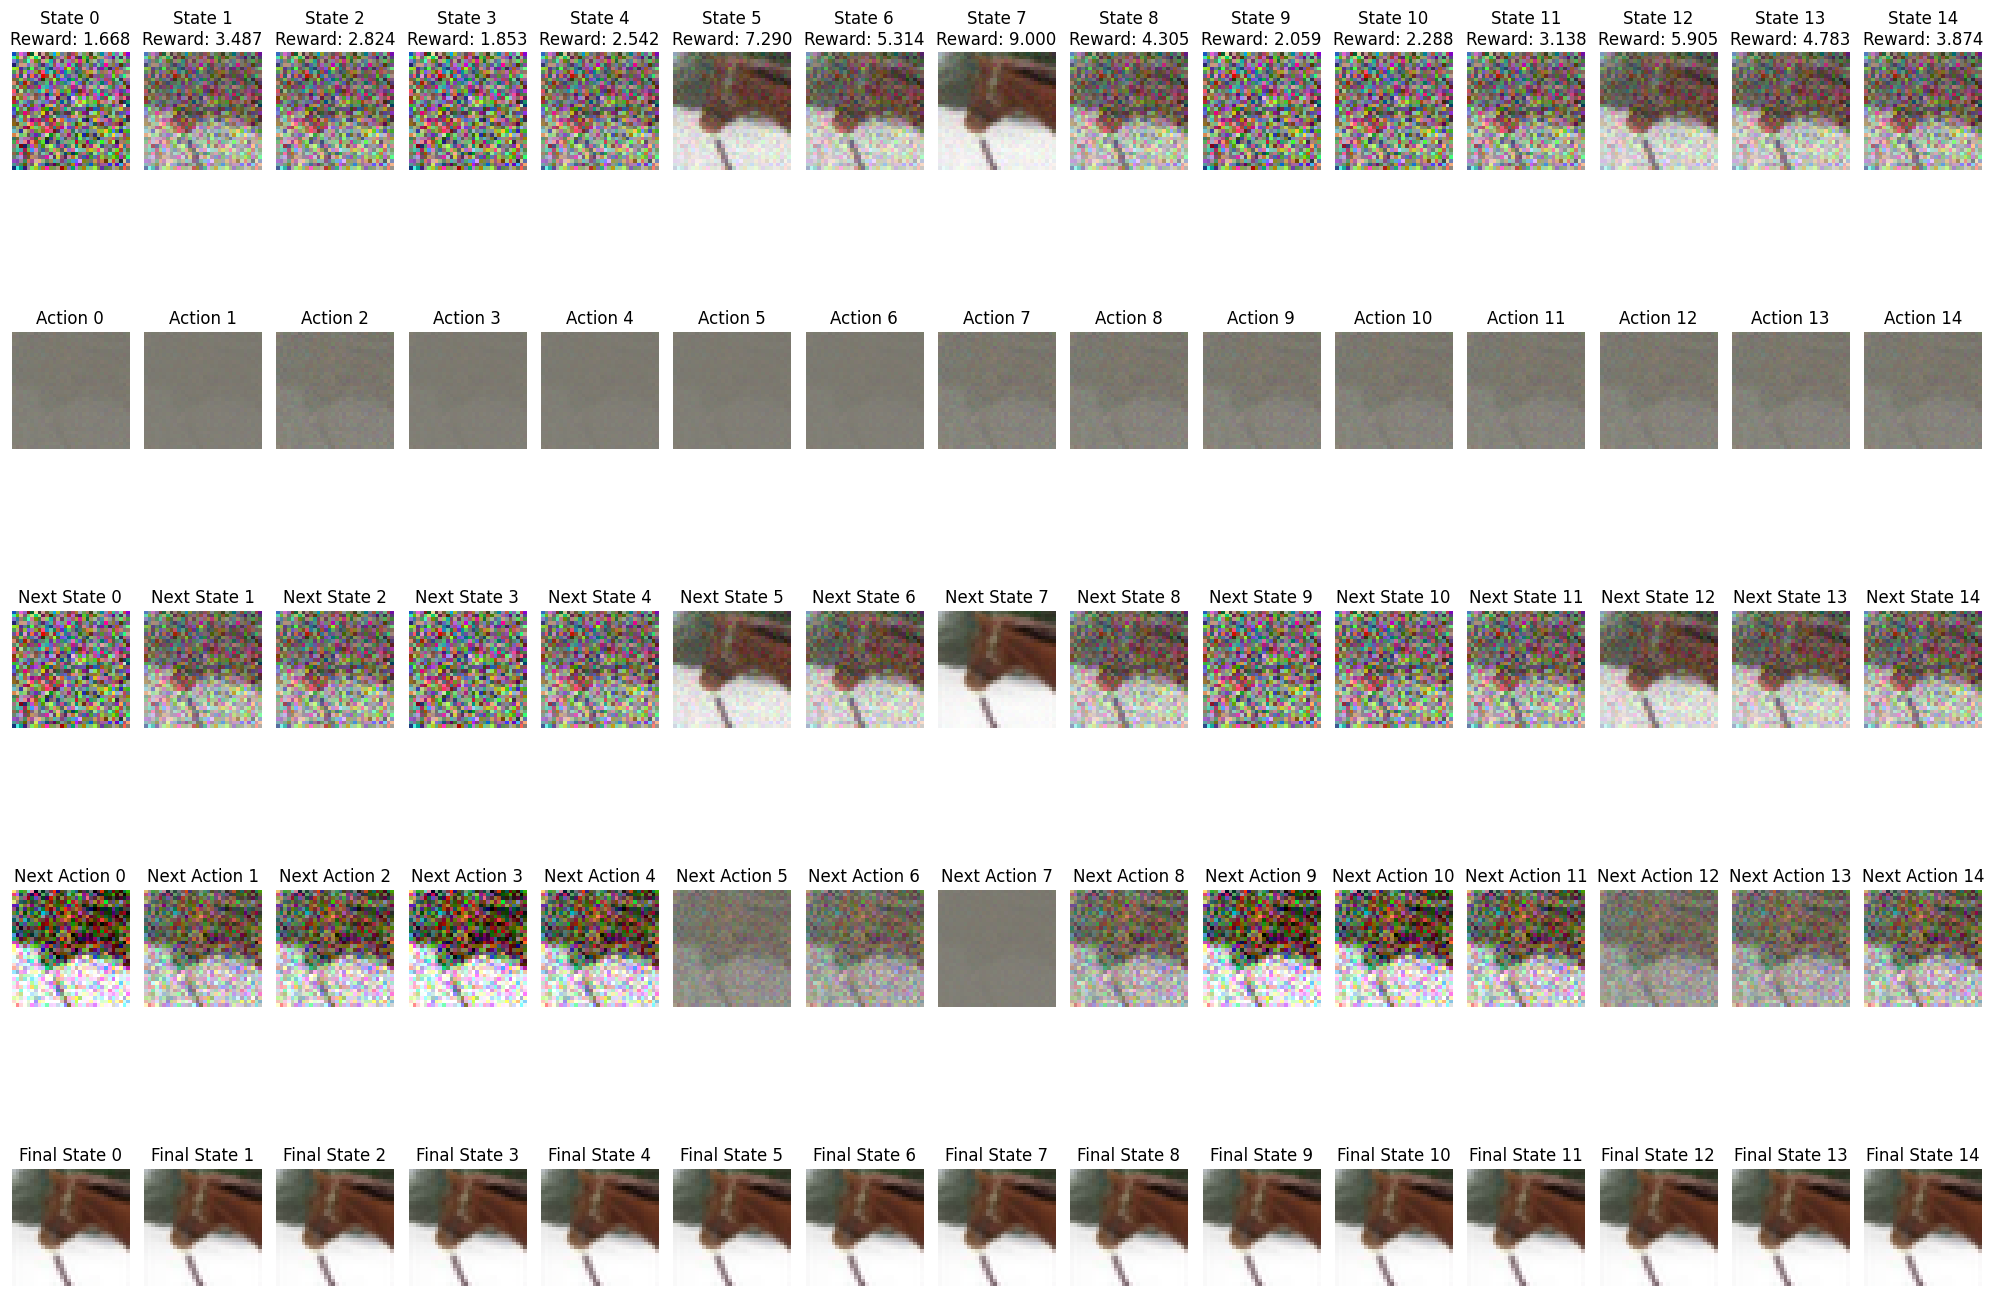

In [11]:
def plot_trajectory(s, a, s_next=None, a_next=None, num_steps=15, with_final_state=True):
    lines = 5 if a_next is not None else 3
    plt.figure(figsize=(20, 3 * lines))

    for i in range(num_steps):
        # State
        plt.subplot(lines, num_steps, i+1)
        plt.imshow((s[i].numpy() * CIFAR10_STD + CIFAR10_MEANS))  # Денормализация
        plt.title(f"State {i}\nReward: {val_rewards[i][0]:.3f}")
        plt.axis('off')

        # Action (визуализируем как разницу)
        plt.subplot(lines, num_steps, num_steps+i+1)
        plt.imshow((a[i].numpy() * CIFAR10_STD + CIFAR10_MEANS))
        plt.title(f"Action {i}")
        plt.axis('off')

        if with_final_state or actions_next is not None:
            # Next State
            s_next = s[i] + a[i] if s_next is None else s_next
            plt.subplot(lines, num_steps, 2*num_steps+i+1)
            plt.imshow((s_next[i].numpy() * CIFAR10_STD + CIFAR10_MEANS))
            plt.title(f"Next State {i}")
            plt.axis('off')
        
        if actions_next is None:
            continue

        a_next = a_next if a_next is not None else None
        plt.subplot(lines, num_steps, 3*num_steps+i+1)
        plt.imshow((a_next[i].numpy() * CIFAR10_STD + CIFAR10_MEANS))
        plt.title(f"Next Action {i}")
        plt.axis('off')

        if with_final_state:
            s_next_next = s_next + a_next
            plt.subplot(lines, num_steps, 4*num_steps+i+1)
            plt.imshow((s_next_next[i].numpy() * CIFAR10_STD + CIFAR10_MEANS))
            plt.title(f"Final State {i}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Визуализируем первую траекторию в батче
plot_trajectory(states, actions, states_next, actions_next, with_final_state=True)

In [7]:
trainer = None

def train_sarsa_td_regressor(*args, num_epochs=200, start_from=0, train=True, **kwargs):
    # Create a trainer module with specified hyperparameters
    global trainer
    trainer = TrainerModule(*args, **kwargs)
    if trainer.checkpoint_exists():
        start_from = trainer.load_model()

    if train:
        print(f"current_epoch = {start_from}")
        trainer.train_model(train_loader,
                            val_loader,
                            rng=jax.random.PRNGKey(42),
                            num_epochs=num_epochs,
                            start_from=start_from)
    # Test trained model
    val_loss = trainer.eval_model(val_loader)
    return trainer, {'val': val_loss}

In [ ]:
googlenet_trainer, googlenet_results = train_sarsa_td_regressor(model_class=RegressionInceptionNetV1,
                                                                model_name="RegressionInceptionNetV1",
                                                                model_hparams={"activation": nn.relu},
                                                                batch_size=bs,
                                                                mode="opt",
                                                                optimizer_name="adamw",
                                                                optimizer_hparams={"lr": 1e-4, "weight_decay": 1e-5},
                                                                exmp_imgs=jax.device_put(next(iter(train_loader))[0]._numpy()[..., :6]),
                                                                num_epochs=500,
                                                                train=True)

2025-04-27 15:38:01.124316: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


current_epoch = 0


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: shapka-pa (shapka-pa-moscow-institute-of-physics-and-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  0%|          | 0/500 [00:00<?, ?it/s]2025-04-27 15:45:35.547384: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-27 15:46:13.820443: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
 11%|█         | 54/500 [5:33:04<45:10:14, 364.61s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x76509084a6b0>>
Traceback (most recent call last):
  File "/home/pvshapka/Q_func_AM/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Проверим предсказания

In [5]:
def load_model(*args, **kwargs):
	trainer = TrainerModule(*args, **kwargs)
	trainer.init_optimizer(num_epochs=500, num_steps_per_epoch=1_000)
	if trainer.checkpoint_exists():
		_ = trainer.load_model()
		
	return trainer

trainer = load_model(model_class=RegressionInceptionNetV1,
					 model_name="RegressionInceptionNetV1",
					 model_hparams={"activation": nn.relu},
					 batch_size=bs,
					 optimizer_name="adamw",
					 optimizer_hparams={"lr": 1e-4,
										"weight_decay": 1e-5},
					 exmp_imgs=jax.device_put(next(iter(train_loader))[0]._numpy()),
					 mode="reversed")

2025-04-28 21:05:15.665920: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-04-28 21:05:15.820467: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [26]:
_, print_loader = get_sarsa_opt_dataloaders(batch_size=bs,
                                      reward=10,
                                      gamma=0.9,
                                      min_num_steps=3,
                                      max_num_steps=23,
                                      with_shuffled_transitions=False)

print_iter = iter(print_loader)

2025-04-28 21:20:32.197530: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


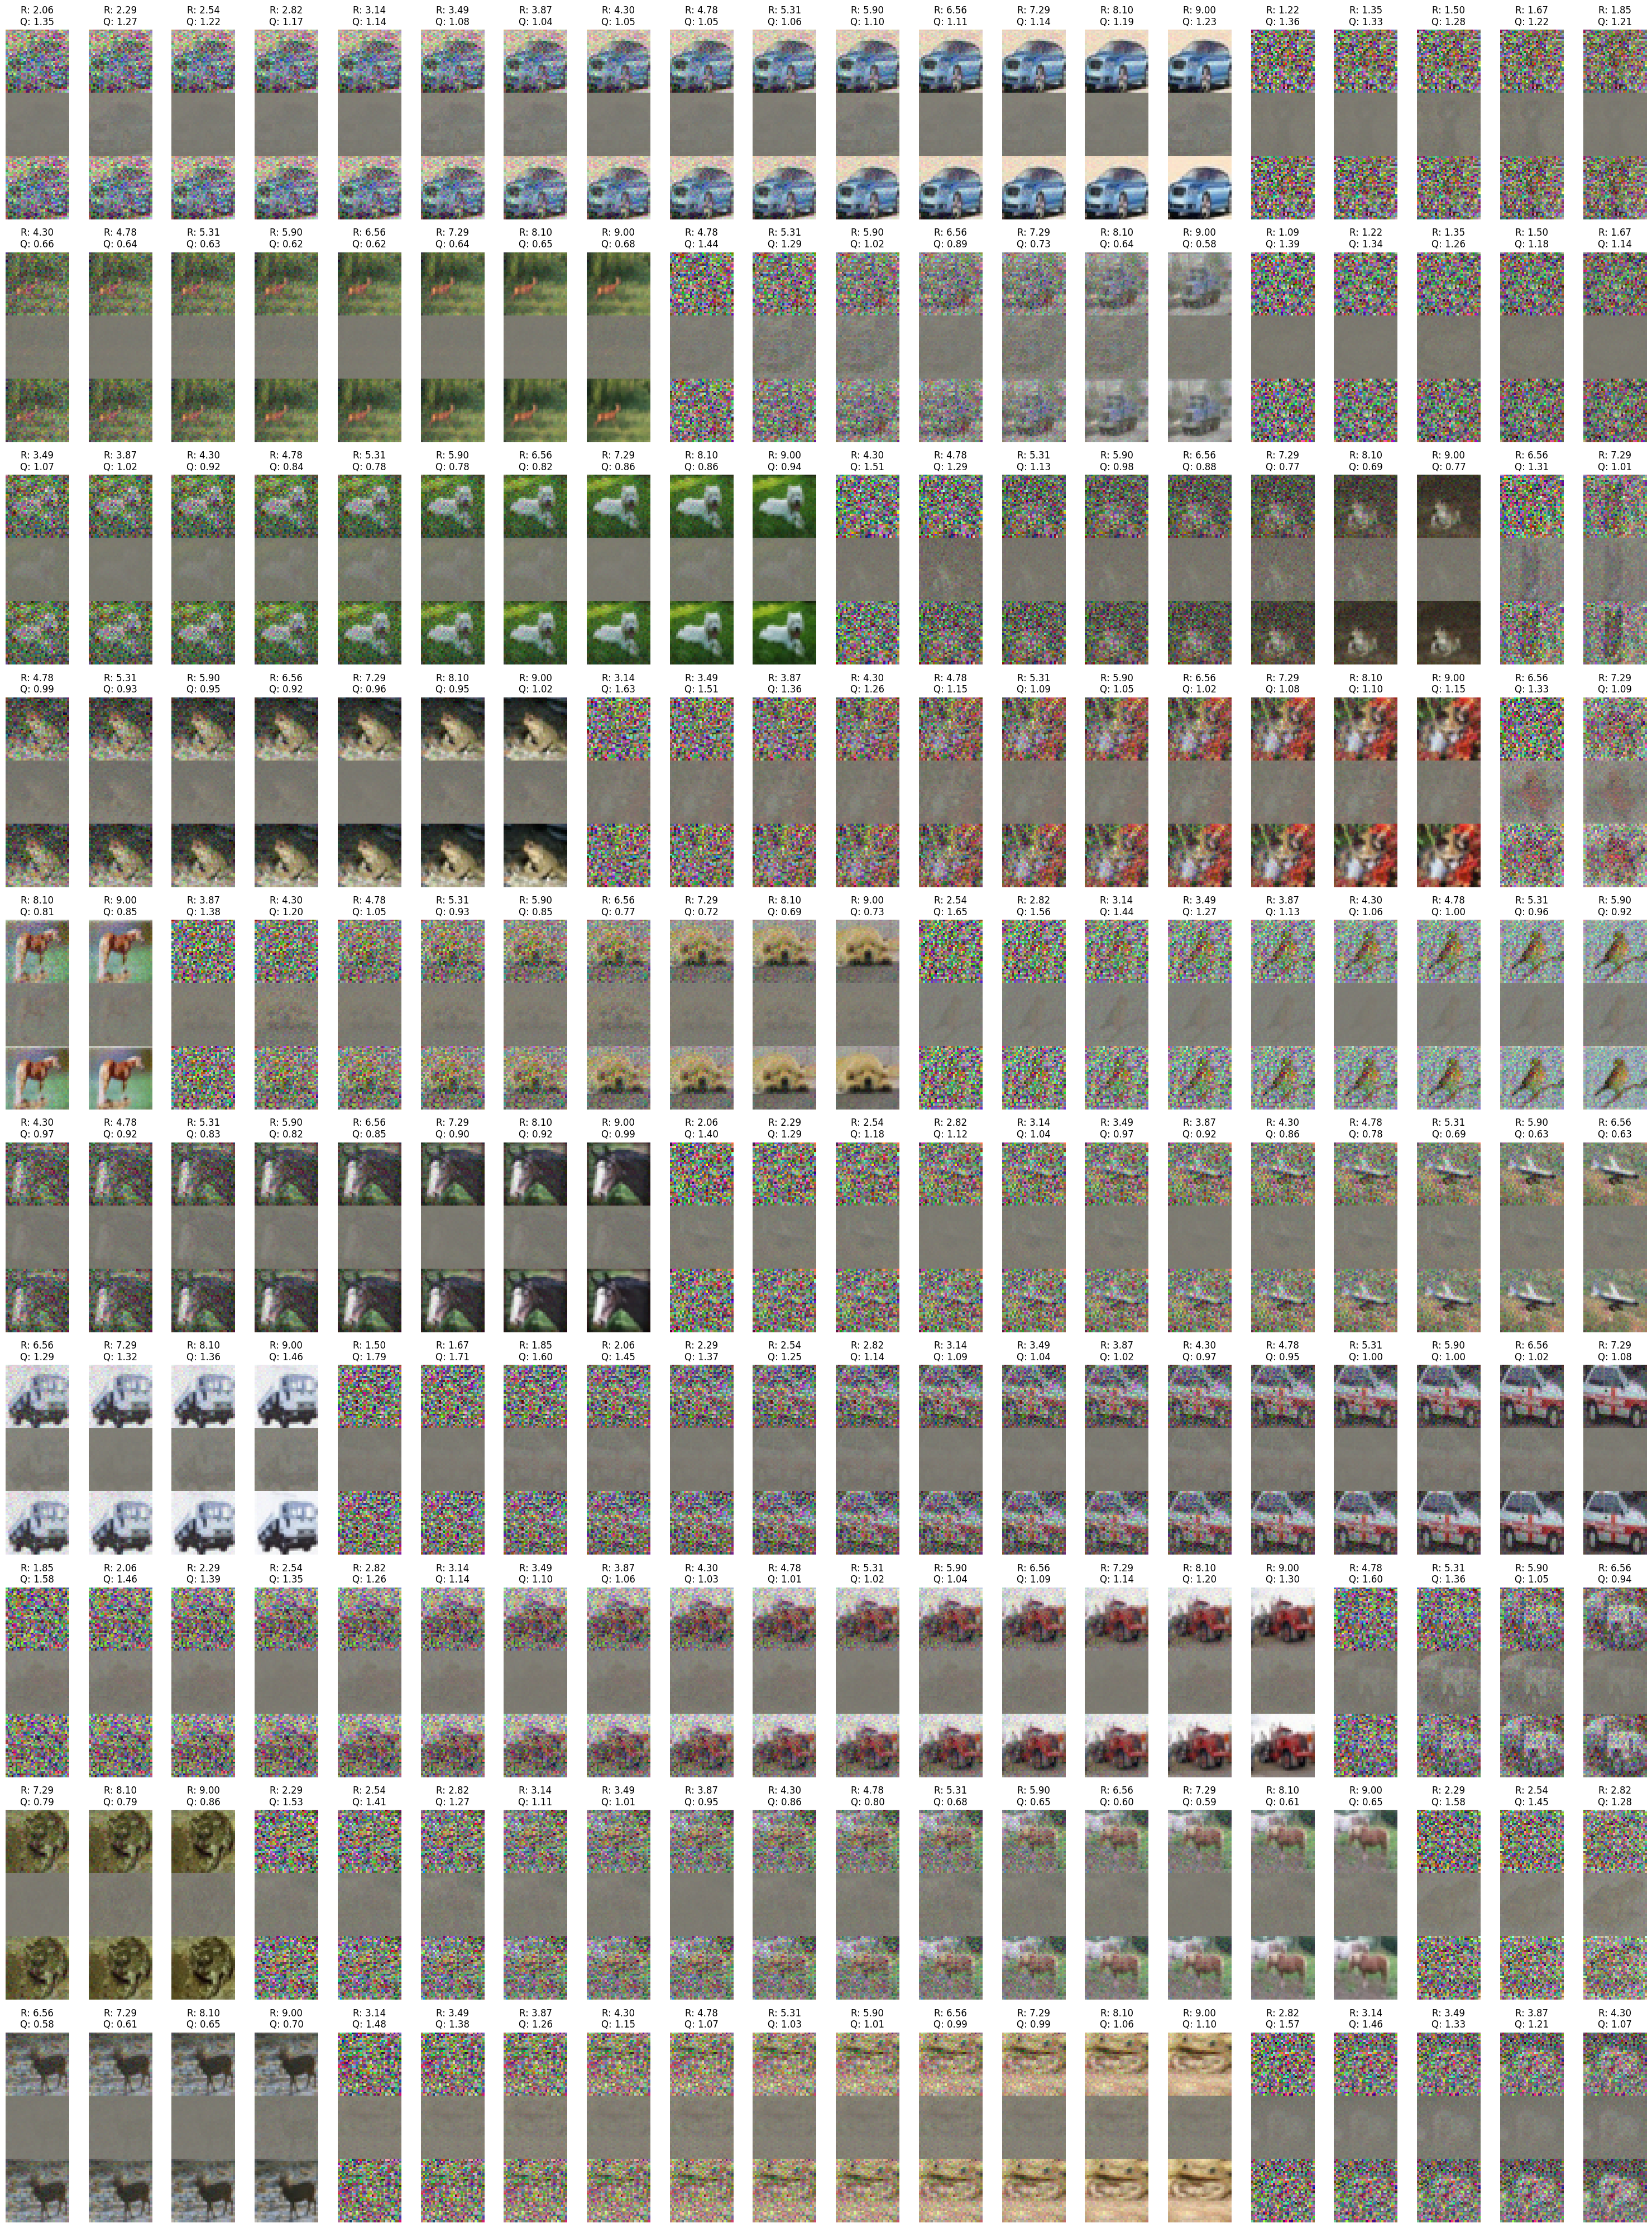

In [30]:
samples_count = 10
wide = 20

plt.figure(figsize=(30, 4 * samples_count))
gs = GridSpec(samples_count, wide)

def extract_one_trajectory(ds_iter):
	sarsa_batch, rewards = next(ds_iter)
	to = 20
	return sarsa_batch[:to+1], rewards[:to+1, 0]


for i in range(samples_count):
	trajectory, rewards = extract_one_trajectory(print_iter)
	traj_length = trajectory.shape[0]

	params, batch_stats = trainer.state.params, trainer.state.batch_stats
	q_values_pred = trainer.model.apply({"params": params, "batch_stats": batch_stats}, trajectory)

	for j in range(min(traj_length, wide)):
		ax = plt.subplot(gs[i, j])
		s = trajectory[j, :, :, :3] * CIFAR10_STD + CIFAR10_MEANS
		a = trajectory[j, :, :, 3:6] * CIFAR10_STD + CIFAR10_MEANS
		s_next = (trajectory[j, :, :, :3] + trajectory[j, :, :, 3:6]) * CIFAR10_STD + CIFAR10_MEANS
		ax.imshow(np.concatenate([s, a, s_next], axis=0))

		ax.axis('off')
		ax.set_title(f"R: {rewards[j]:.2f}\nQ: {q_values_pred[j, 0]:.2f}")

plt.tight_layout()
plt.show()

In [ ]:
samples_count = 10

plt.figure(figsize=(20, 2 * samples_count))
gs = GridSpec(samples_count, 20)

def extract_one_trajectory(ds_iter):
    sarsa_batch, rewards = next(ds_iter)
    to = rewards[0] == 10
    return sarsa_batch[to], rewards[to]
    

for _ in range(10):
	trajectory, rewards = extract_one_trajectory(val_iter)
	traj_length = trajectory.shape[0]

	params, batch_stats = trainer.state.params, trainer.state.batch_stats
	q_values_pred = trainer.model.apply({"params": params, "batch_stats": batch_stats}, trajectory)

	for j in range(traj_length):
		ax = plt.subplot(gs[i, j])
		ax.imshow(trajectory[j].numpy() * CIFAR10_STD + CIFAR10_MEANS)

		ax.axis('off')
		ax.set_title(f"R: {rewards[j]:.2f}\nQ: {q_values_pred[j]:.2f}")

plt.tight_layout()
plt.show()
		